In [184]:
%matplotlib notebook


In [2]:

import numpy as np
import pandas as pd

import geopy.distance

import math
import radartrack as rt
from PIL import Image as Image
from pprint import pprint

import beeview

import matplotlib.pyplot as plt

In [46]:
data = pd.read_csv('coors_menzel_panos.txt', sep=';', header=None)

In [47]:
data

,0,1,2
0,Fig_5_A_B_Hive,"50°48'51.83""N","8°52'20.67""E"
1,Fig_5_A_B_Feeder,"50°49'3.68""N","8°52'14.60""E"
2,Fig_5_A_B_Release_site,"50°49'10.94""N","8°52'40.14""E"
3,Fig_6_A_B_C_Hive,"50°48'51.83""N","8°52'20.67""E"
4,Fig_6_A_B_C_Feeder_F1,"50°48'58.31""N","8°52'33.31""E"
5,Fig_6_A_B_C_Release_site,"50°48'55.18""N","8°52'59.66""E"
6,Fig_7_A_-_G_hive,"50°48'39.96""N","8°52'42.09""E"
7,Fig_7_A_-_G_Release_site_400_m,"50°48'53.54""N","8°52'40.19""E"
8,Fig_7_A_-_G_Release_site_800_m,"50°49'4.20""N","8°52'38.97""E"
9,Fig_7_A_-_G_Release_site_1000_m,"50°49'11.87""N","8°52'37.32""E"


In [48]:
import re

def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\.\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    lng = dms2dd(parts[4], parts[5], parts[6], parts[7])

    return [lat, lng]

In [5]:
# convert the dms coordinates to dd coordinates

res = []
for i in range(data.shape[0]):
    res.append([i]+parse_dms(data.loc[i,1]+" "+data.loc[i,2]))

In [6]:
# save as csv txt

np.savetxt("coords_dd.txt", res, delimiter=",", fmt="%10.10f")

In [44]:
# load from disk

coords_to_render = np.genfromtxt("coords_dd.txt", delimiter=",")

In [49]:
# get the names of the places (e.g. "Fig_5_A_B_Hive")

labels = data[0].tolist()

In [50]:
def convert_coords(coords):
    """ convert the gps coordinates to the coordinates used by beeview """
    
    radar_coords = (50.814512, 8.872433) # from google maps
    
    dist_y = geopy.distance.geodesic(radar_coords,(coords[0],radar_coords[1])).m
    dist_x = geopy.distance.geodesic(radar_coords,(radar_coords[0],coords[1])).m
    
    if radar_coords[1] > coords[1]:
        dist_x *= (-1)
        
    if radar_coords[0] > coords[0]:
        dist_y *= (-1)
    
    return (dist_x,dist_y)

In [51]:
# start movie maker and load scene 

movie_maker = rt.movie.MovieMaker(scene='hessen_2016') 

In [125]:
markers = []

for i, coords in enumerate(coords_to_render):

    movie_maker.renderer.mode = beeview.Renderer.BeeEye
    movie_maker.renderer.set_ommatidium_size(1)

    p = convert_coords((coords[1],coords[2]))
    
    markers.append(rt.map.Marker(p,size=50, label=labels[i]))

    pos = movie_maker.to_3D_coordinates(p, height = 4)
    movie_maker.renderer.position = pos

    # west
    movie_maker.renderer.direction = [-1,0,0]

    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/beeview_west_"+labels[i]+".png")

    # change direction to east
    movie_maker.renderer.direction = [1,0,0]

    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/beeview_east_"+labels[i]+".png")
    
"""
    # panoramic image
    movie_maker.renderer.mode = beeview.Renderer.Panoramic
    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/pano_"+labels[i]+".png")
"""

'\n    # panoramic image\n    movie_maker.renderer.mode = beeview.Renderer.Panoramic\n    image = movie_maker.renderer.render()\n\n    # save the image\n    Image.fromarray(image).save("menzel_panos_1px/pano_"+labels[i]+".png")\n'

<IPython.core.display.Javascript object>


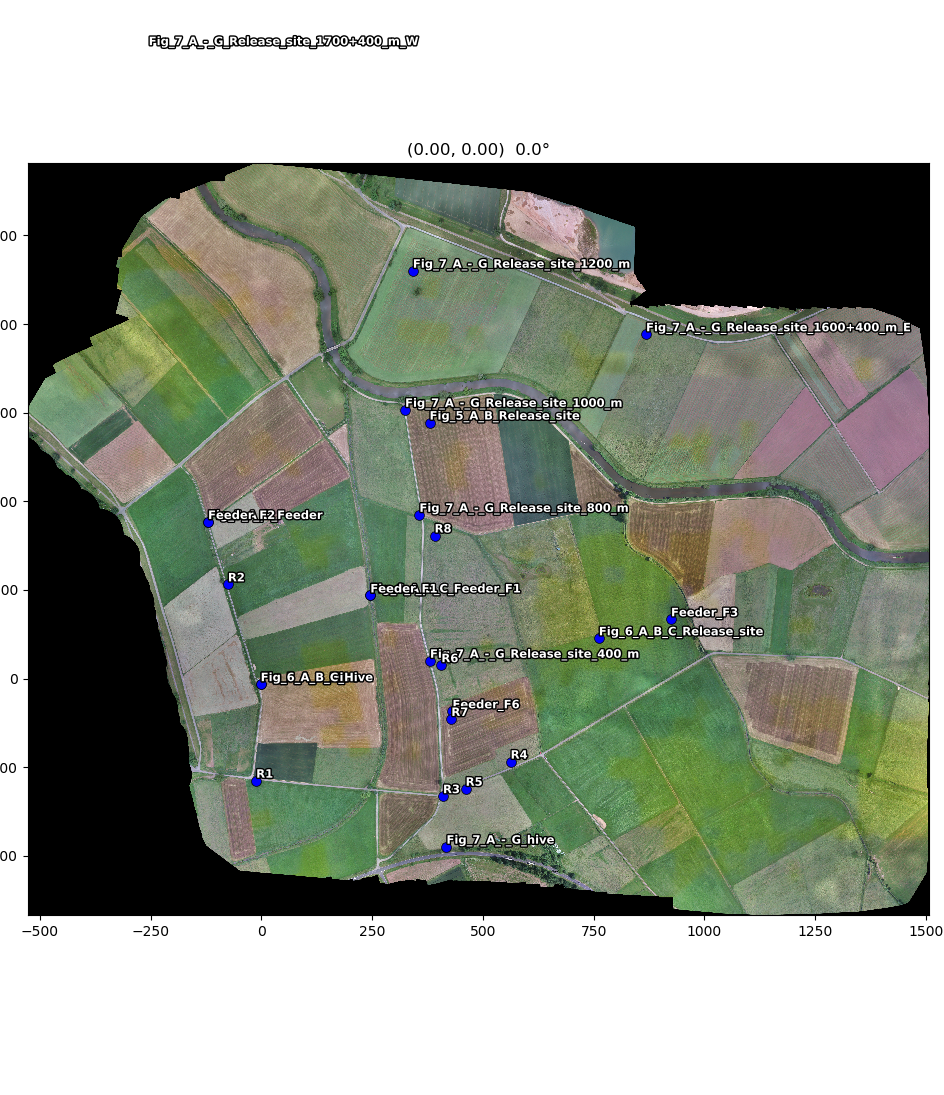

In [59]:
# plot the positions

plotter = rt.plot.Plotter()
plotter.new_figure(figsize=(16, 12)) \
       .set_map( rt.data.maps['drone_map', 'color_small']) \
       .set_markers(markers) \
       .plot() \
       .show()

In [223]:
# calculate the michelson contrast for all images

import glob
import os

# load beeviews from disk

images = []
ids = []
for filename in glob.glob('menzel_panos_1px/beeview*.png'):
    
    ids.append(os.path.splitext(os.path.basename(filename))[0])
    
    images.append((np.array(Image.open(filename)) @ [0.299, 0.587, 0.114])/255)

In [224]:
images = np.array(images)

In [225]:
images.shape

(48, 131, 112)

In [226]:
images = images.reshape(48,131*112) # make that each image is 1 array

In [227]:
images[images == 0] = np.nan
images[images == 1] = np.nan

<IPython.core.display.Javascript object>


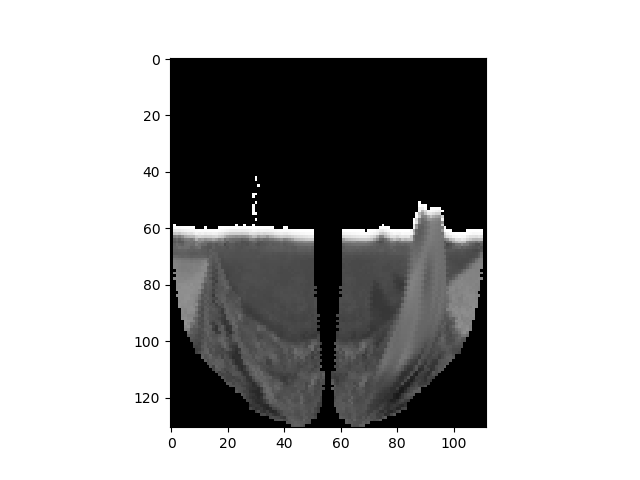

In [228]:
im = images[0].reshape(131,112)
im[np.isnan(im)] = 0
plt.imshow(im, cmap="gray")
plt.show()

In [229]:
contrast = (np.nanmax(images, axis=1) - np.nanmin(images, axis=1))/(np.nanmax(images, axis=1) + np.nanmin(images, axis=1))

In [230]:
std = np.nanstd(images,axis=1)
mean = np.nanmean(images,axis=1)

In [231]:
# mask of the ground area
images = images.reshape(48,131,112)
images[:,0:68,:] = np.nan

<IPython.core.display.Javascript object>


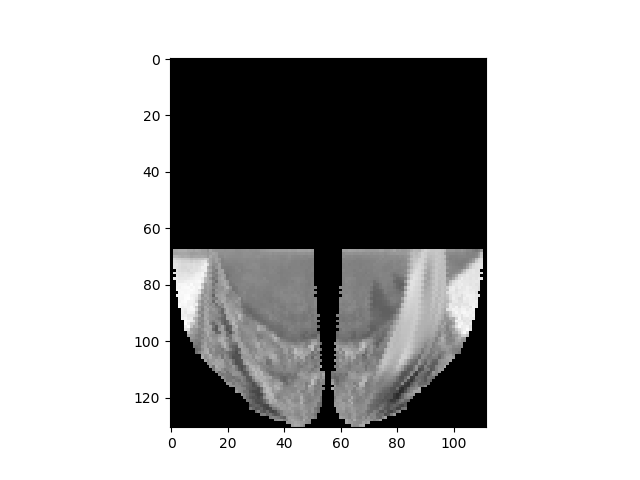

In [232]:
im = images[0]
im[np.isnan(im)] = 0
plt.imshow(images[0], cmap="gray")
plt.show()

In [233]:
images = images.reshape(48,131*112) # make that each image is 1 array

In [234]:
contrast_masked = (np.nanmax(images, axis=1) - np.nanmin(images, axis=1))/(np.nanmax(images, axis=1) + np.nanmin(images, axis=1))

In [235]:
df = pd.DataFrame(data = {"ID": ids, "contrast": contrast, "contrast_masked": contrast_masked})
df

,ID,contrast,contrast_masked
0,beeview_east_Feeder_F1,1.000000,1.000000
1,beeview_east_Feeder_F2,0.768956,0.691832
2,beeview_east_Feeder_F3,0.724495,0.508960
3,beeview_east_Feeder_F6,0.649897,0.348952
4,beeview_east_Fig_5_A_B_Feeder,0.768956,0.691832
5,beeview_east_Fig_5_A_B_Hive,0.752878,0.702777
6,beeview_east_Fig_5_A_B_Release_site,0.706419,0.509459
7,beeview_east_Fig_6_A_B_C_Feeder_F1,0.827707,0.718450
8,beeview_east_Fig_6_A_B_C_Hive,0.752878,0.702777
9,beeview_east_Fig_6_A_B_C_Release_site,0.582952,0.234711


In [236]:
df.to_csv("contrasts.csv", index=False)

In [237]:
print("contrast_mean: " + str(contrast.mean()))
print("contrast_std: " + str(contrast.std()))
print("contrast_masked_mean: " + str(contrast_masked.mean()))
print("contrast_masked_std: " + str(contrast_masked.std()))

contrast_mean: 0.724312129239
contrast_std: 0.0753873609351
contrast_masked_mean: 0.547106049197
contrast_masked_std: 0.158299222508
